In [1]:
import csv
import numpy as np

images, labels = [], []

with open('train.csv') as train_file:
    # Skip first line.
    train_file.readline()
    
    csv_train_file = csv.reader(train_file, delimiter=',')
    for row in csv_train_file:
        labels.append(row[0])
        images.append(np.array(row[1:], dtype=float))

In [2]:
##############################################################
#           Part One: Preprocess Data 1) Explore
##############################################################

Printing sample with label 8.


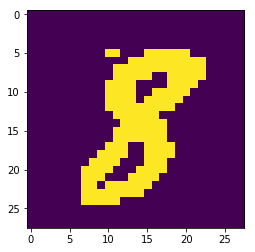

In [3]:
sample_index = 20

import matplotlib
from matplotlib import pyplot as plt

sample, label = images[sample_index], labels[sample_index]
plt.imshow(np.reshape(sample, (28, 28)), norm=matplotlib.colors.NoNorm())

print("Printing sample with label %s." % (label))
plt.show()

Printing sample with normalzied pixels.


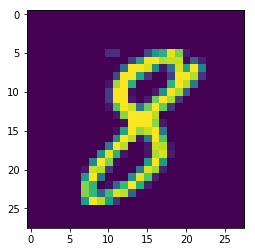

In [4]:
# Normalizing a sample to scale of (0, 1)

PIXEL_SCALE = 255
normalized_sample = sample / PIXEL_SCALE
plt.imshow(np.reshape(normalized_sample, (28, 28)), norm=matplotlib.colors.NoNorm())
print("Printing sample with normalzied pixels.")
plt.show()

In [5]:
normalized_images = [image / PIXEL_SCALE for image in images]

In [6]:
################################################################
#           Part One: Preprocess Data 2) Split Data Set
################################################################

In [7]:
# One hot encoding labels.
def one_hot_label(label):
    one_hot_coded = np.zeros(10)
    one_hot_coded[int(label)] = 1
    return np.array(one_hot_coded)

In [8]:
import random

combined = list(zip(images, labels))
random.shuffle(combined)
images[:], labels[:] = zip(*combined)

validation_size = int(len(images) / 10)

validate_images = [np.array(image).reshape((28, 28, 1)) for image in images[:validation_size]]
validate_labels = [one_hot_label(label) for label in labels[:validation_size]]

images = images[validation_size:]
labels = labels[validation_size:]


In [9]:
import tensorflow as tf

/Users/Carter/anaconda2/envs/dlnd/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [10]:
################################################################
#                Part Two: (1) Create Tensor
################################################################

In [11]:
def conv_net_input(input_shape):
    tensor_shape = [None] + list(input_shape)
    return tf.placeholder(tf.float32, shape=tensor_shape, name='conv_input')

def conv_net_label(label_shape):
    label_shape = [None, label_shape]
    return tf.placeholder(tf.float32, shape=label_shape, name='conv_label')

def conv_net_dropout_prob():
    return tf.placeholder(tf.float32, name='dropout_prob')

In [12]:
##############################################################
#                Part Two: (2) Create Layer
##############################################################

In [13]:
def conv2d(input_tensor, kernel_depth=1, output_dim=32, k_size=3, padding='valid'):
    """
    :param input_tensor: input tensor, should be reshaped to 2D
    :param output_dim: output dimension, e.g. 32, 64, etc. 
    :param kernel_size: kernel size, 3, 5, etc.
    """
    conv_layer = tf.layers.conv2d(input_tensor,
                                  output_dim,
                                  k_size,
                                  padding=padding,
                                  activation=tf.nn.relu)
    
    return conv_layer

In [14]:
def max_pool(input_tensor, pool_ksize, pool_strides, padding='valid'):
    return tf.layers.max_pooling2d(
        input_tensor,
        pool_ksize,
        pool_strides,
        padding
    )

In [15]:
from functools import reduce

def flatten(input_tensor):
    image_dimension = reduce(lambda a,b: a*b, input_tensor.get_shape().as_list()[1:])    
    return tf.reshape(input_tensor, [-1, image_dimension])

In [16]:
def fully_connected_with_dropout(input_tensor, output_dim, dropout):    
    fully_connected = tf.layers.dense(
        input_tensor,
        output_dim,
    )
    
    dropout_layer = tf.layers.dropout(inputs=fully_connected, rate=dropout)    
    
    return dropout_layer

In [17]:
def output_layer(input_tensor, output_dim):    
    return tf.layers.dense(
        input_tensor,
        output_dim,
    )

In [54]:
class BatchLoader:
    
    def __init__(self, images=[], label=[]):
        self.images = images
        self.labels = labels
        self.offset = 0
        
    def load_batch_image(self, batch_size):
        i = self.offset
        image_batch = self.images[i: i + batch_size]
        image_batch = [image.reshape((28, 28, 1)) for image in image_batch]       
        self.offset += batch_size
        return image_batch
        
    def load_batch(self, batch_size):        
        i = self.offset
        image_batch = self.images[i: i + batch_size]
        image_batch = [image.reshape((28, 28, 1)) for image in image_batch]
                
        label_batch = self.labels[i: i + batch_size]
        label_batch = [one_hot_label(label) for label in label_batch]
        self.offset += batch_size
                
        return image_batch, label_batch
        
    def reset(self):
        self.offset = 0

In [19]:
##############################################################
#                Part Two: (3) Create Model
##############################################################

In [20]:
def conv_net(image, dropout_prob):
    """
    :param image: input image tensor.
    :dropout_prob: drop out probability.
    """
    # convolution - max pooling layer 1
    conv_layer = conv2d(image, kernel_depth=1, output_dim=16, k_size=3)
    mp_layer = max_pool(conv_layer, 2, 2)
    
    # convolution - max pooling layer 2
    conv_layer = conv2d(mp_layer, kernel_depth=16, output_dim=32, k_size=3)
    mp_layer = max_pool(conv_layer, 2, 2)
    
    # convolution - max pooling layer 3
    conv_layer = conv2d(mp_layer, kernel_depth=32, output_dim=64, k_size=3)
    mp_layer = max_pool(conv_layer, 2, 2)
    
    flat = flatten(mp_layer)
    
    # def fully_connected_with_dropout(input_tensor, output_dim, dropout):
    
    fully_conn = fully_connected_with_dropout(flat, 96, dropout_prob) 
    logits = output_layer(fully_conn, 10)
    
    return logits

In [21]:
##############################################################
#                Part Three: Define Loss & Accuracy
##############################################################

In [38]:
tf.reset_default_graph()

image_tensor = conv_net_input((28, 28, 1))
label_tensor = conv_net_label(10)
dropout_prob_tensor = conv_net_dropout_prob()

# Module

logits = conv_net(image_tensor, dropout_prob_tensor)
logits = tf.identity(logits, name='logits')

# Loss & Optimizer
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=label_tensor))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

correct_pred = tf.equal(tf.argmax(logits, axis=1), tf.argmax(label_tensor, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [39]:
from functools import reduce
reduce((lambda a,b: a*b), [1,2], 1)

2

In [40]:
def print_stats(session,
                image_batch,
                label_batch,
                validation_image_batch,
                validation_label_batch,
                t_loss_seq,
                v_loss_seq
               ):
    
    t_loss = session.run(loss, feed_dict={
        image_tensor : image_batch,
        label_tensor : label_batch,
        dropout_prob_tensor : 0.0
    })
    
    t_loss_seq.append(t_loss)

    t_accuracy = session.run(accuracy, feed_dict={
        image_tensor : image_batch,
        label_tensor : label_batch,
        dropout_prob_tensor : 0.0     
    })
    
    v_loss = session.run(loss, feed_dict={
        image_tensor : validation_image_batch,
        label_tensor : validation_label_batch,
        dropout_prob_tensor : 0.0
    })
    
    v_loss_seq.append(v_loss)
    
    v_accuracy = session.run(accuracy, feed_dict={
        image_tensor : validation_image_batch,
        label_tensor : validation_label_batch,
        dropout_prob_tensor : 0.0     
    })
        
    print('Training loss: ', t_loss)
    print('Validation loss: ', v_loss)

    print('Training accuracy: ', t_accuracy)
    print('Validation accuracy: ', v_accuracy)



In [41]:
##############################################################
#                Part Four: Training
##############################################################

In [42]:
from matplotlib import pyplot as plt

In [43]:
def train_model(session, optimizer, image_batch, label_batch, dropout_prob):
    
#     print('image_batch shape: ', len(image_batch))
#     print('label_batch shape: ', len(label_batch))
#     print('dropout_prob shape: ', dropout_prob)
    
    session.run(
        optimizer,
        feed_dict={
            image_tensor : image_batch,
            label_tensor : label_batch,
            dropout_prob_tensor : dropout_prob
        }
    )

In [44]:
save_model_path = './kaggle_digit'

def run_model(epochs, images, labels, batch_size, dropout_prob):
    
    t_loss_seq, v_loss_seq = [], []    
    
    with tf.Session() as session:
        
        # Initializing the variables
        session.run(tf.global_variables_initializer())
    
        # Prepare batches for images & labels
        loader = BatchLoader(images, labels)
    
        for epoch in range(epochs):
            loader.reset()
            
            count = 0
            
            while True:                
                image_batch, label_batch = loader.load_batch(batch_size)
                count += 1
                
                # Process each batch.
                if len(image_batch) != 0  and len(label_batch) != 0:                     
                    train_model(session, optimizer, image_batch, label_batch, dropout_prob)
                    
                    # Print stats every 7 epochs.
                    if count % 7 == 0:
                        print('===============epoch: ', epoch, '=================')
                        print_stats(session, image_batch, label_batch, 
                                    validate_images, validate_labels,
                                    t_loss_seq, v_loss_seq)
                        
                        ## Plot out training loss vs validation loss.
                        time_series = range(len(t_loss_seq))
                        plt.plot(time_series, t_loss_seq)
                        plt.plot(time_series, v_loss_seq)
                        plt.legend(['training_loss', 'validation_loss'])

                        plt.show()
                else:
                    break
                    
        saver = tf.train.Saver()
        save_path = saver.save(session, save_model_path)
                    


===============epoch:  0 =================
Training loss:  11.3908
Validation loss:  12.2373
Training accuracy:  0.186667
Validation accuracy:  0.169762


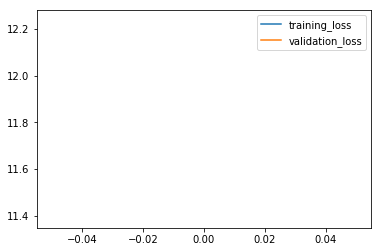

===============epoch:  0 =================
Training loss:  4.9998
Validation loss:  5.1877
Training accuracy:  0.43
Validation accuracy:  0.441429


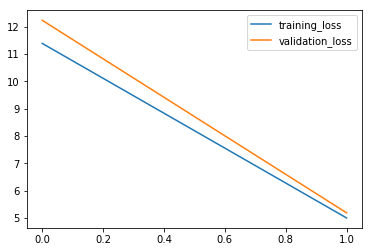

===============epoch:  0 =================
Training loss:  2.26196
Validation loss:  2.72227
Training accuracy:  0.56
Validation accuracy:  0.506429


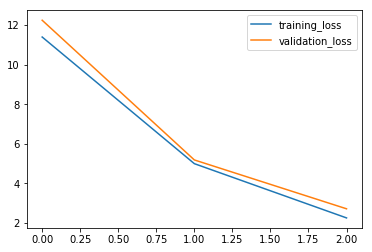

===============epoch:  0 =================
Training loss:  1.68847
Validation loss:  1.62662
Training accuracy:  0.616667
Validation accuracy:  0.627619


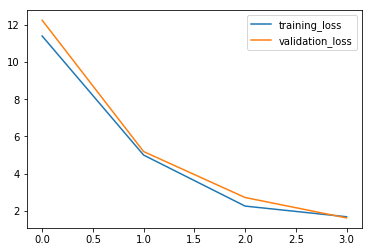

===============epoch:  0 =================
Training loss:  1.29812
Validation loss:  1.35321
Training accuracy:  0.685
Validation accuracy:  0.668095


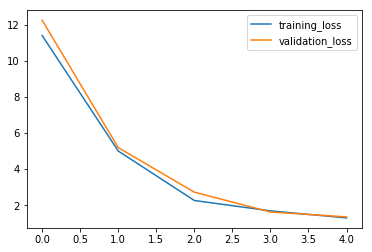

===============epoch:  0 =================
Training loss:  1.06844
Validation loss:  1.1318
Training accuracy:  0.726667
Validation accuracy:  0.705714


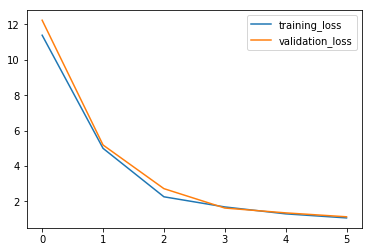

===============epoch:  0 =================
Training loss:  1.07127
Validation loss:  0.975712
Training accuracy:  0.743333
Validation accuracy:  0.736429


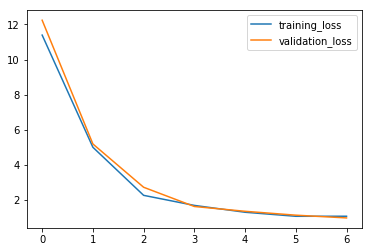

===============epoch:  0 =================
Training loss:  0.713742
Validation loss:  0.869775
Training accuracy:  0.795
Validation accuracy:  0.759048


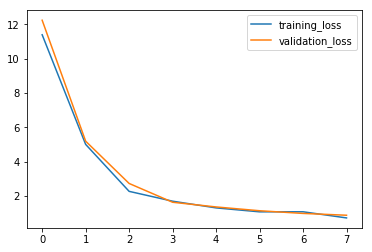

===============epoch:  0 =================
Training loss:  0.682673
Validation loss:  0.78494
Training accuracy:  0.801667
Validation accuracy:  0.779524


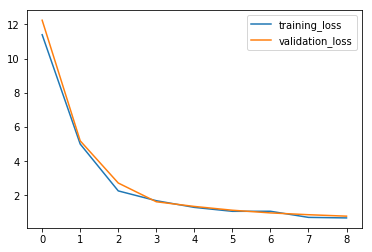

===============epoch:  1 =================
Training loss:  0.666847
Validation loss:  0.731358
Training accuracy:  0.8
Validation accuracy:  0.797619


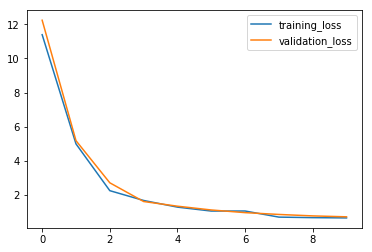

===============epoch:  1 =================
Training loss:  0.711379
Validation loss:  0.68085
Training accuracy:  0.796667
Validation accuracy:  0.80881


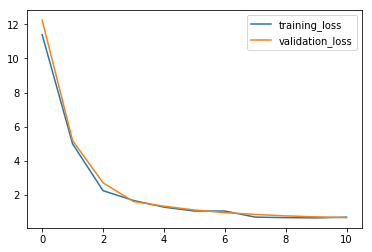

===============epoch:  1 =================
Training loss:  0.531495
Validation loss:  0.626417
Training accuracy:  0.855
Validation accuracy:  0.823095


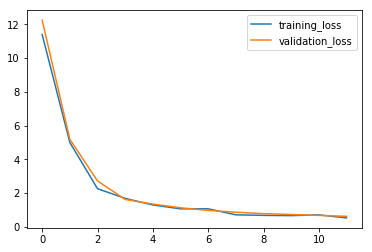

===============epoch:  1 =================
Training loss:  0.626867
Validation loss:  0.598451
Training accuracy:  0.808333
Validation accuracy:  0.831667


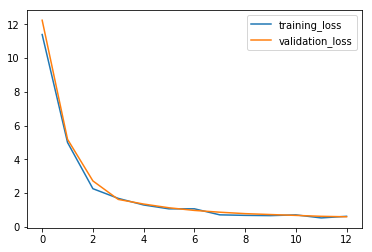

===============epoch:  1 =================
Training loss:  0.527088
Validation loss:  0.543235
Training accuracy:  0.858333
Validation accuracy:  0.84381


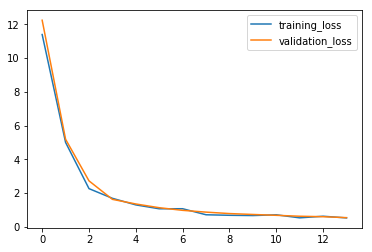

===============epoch:  1 =================
Training loss:  0.412695
Validation loss:  0.511177
Training accuracy:  0.873333
Validation accuracy:  0.860476


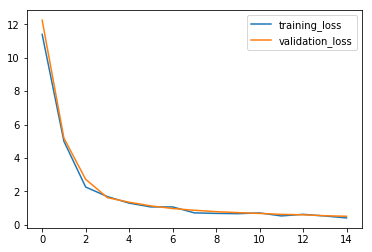

===============epoch:  1 =================
Training loss:  0.44147
Validation loss:  0.480832
Training accuracy:  0.871667
Validation accuracy:  0.865476


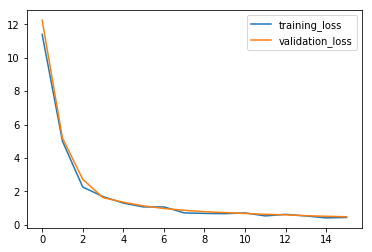

===============epoch:  1 =================
Training loss:  0.352125
Validation loss:  0.462063
Training accuracy:  0.91
Validation accuracy:  0.874048


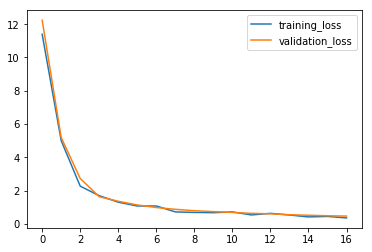

===============epoch:  1 =================
Training loss:  0.35384
Validation loss:  0.438761
Training accuracy:  0.886667
Validation accuracy:  0.879524


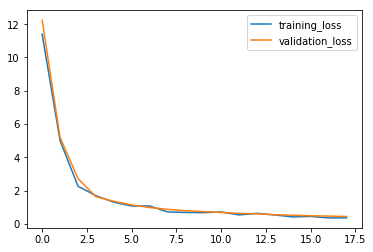

===============epoch:  2 =================
Training loss:  0.362688
Validation loss:  0.424868
Training accuracy:  0.896667
Validation accuracy:  0.880476


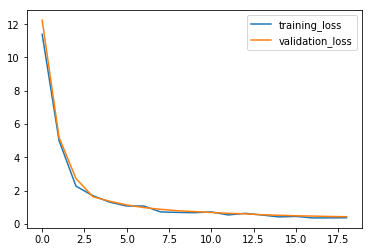

===============epoch:  2 =================
Training loss:  0.430694
Validation loss:  0.429113
Training accuracy:  0.875
Validation accuracy:  0.884524


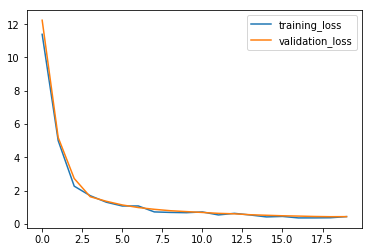

===============epoch:  2 =================
Training loss:  0.328486
Validation loss:  0.393861
Training accuracy:  0.905
Validation accuracy:  0.889524


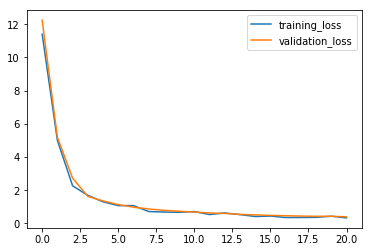

===============epoch:  2 =================
Training loss:  0.376905
Validation loss:  0.390002
Training accuracy:  0.878333
Validation accuracy:  0.89619


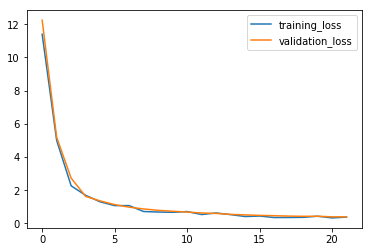

===============epoch:  2 =================
Training loss:  0.299262
Validation loss:  0.357955
Training accuracy:  0.901667
Validation accuracy:  0.900476


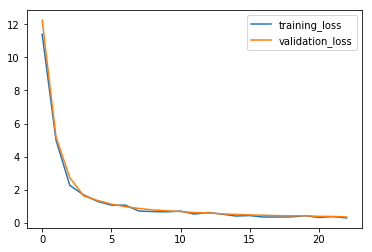

===============epoch:  2 =================
Training loss:  0.249472
Validation loss:  0.347134
Training accuracy:  0.925
Validation accuracy:  0.904762


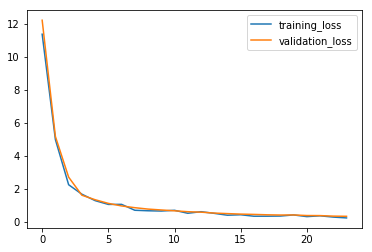

===============epoch:  2 =================
Training loss:  0.266053
Validation loss:  0.331443
Training accuracy:  0.92
Validation accuracy:  0.909048


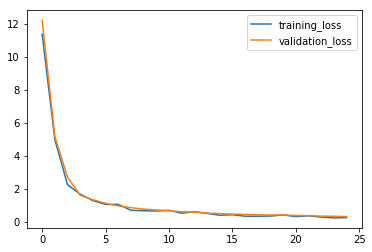

===============epoch:  2 =================
Training loss:  0.231406
Validation loss:  0.326699
Training accuracy:  0.93
Validation accuracy:  0.91


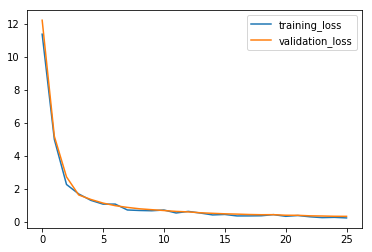

===============epoch:  2 =================
Training loss:  0.249379
Validation loss:  0.320683
Training accuracy:  0.923333
Validation accuracy:  0.91


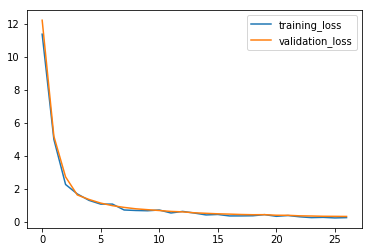

===============epoch:  3 =================
Training loss:  0.25346
Validation loss:  0.316857
Training accuracy:  0.925
Validation accuracy:  0.915476


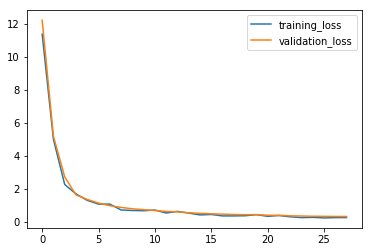

===============epoch:  3 =================
Training loss:  0.306714
Validation loss:  0.325079
Training accuracy:  0.906667
Validation accuracy:  0.908333


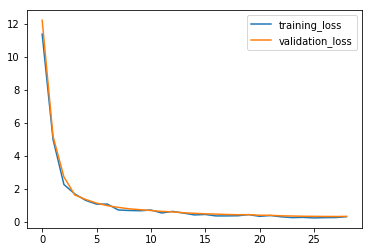

===============epoch:  3 =================
Training loss:  0.249592
Validation loss:  0.303291
Training accuracy:  0.928333
Validation accuracy:  0.916905


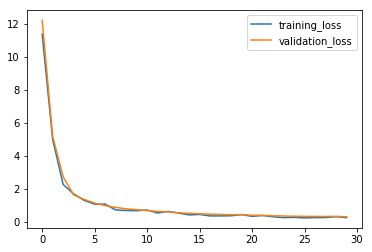

===============epoch:  3 =================
Training loss:  0.253285
Validation loss:  0.302347
Training accuracy:  0.913333
Validation accuracy:  0.912857


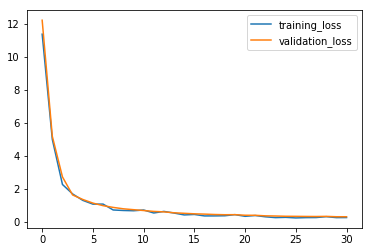

===============epoch:  3 =================
Training loss:  0.191572
Validation loss:  0.28106
Training accuracy:  0.943333
Validation accuracy:  0.920238


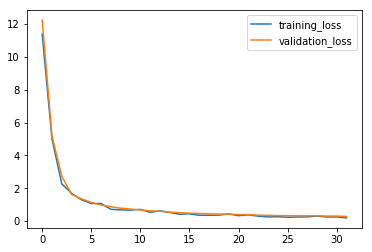

===============epoch:  3 =================
Training loss:  0.188462
Validation loss:  0.277475
Training accuracy:  0.941667
Validation accuracy:  0.92381


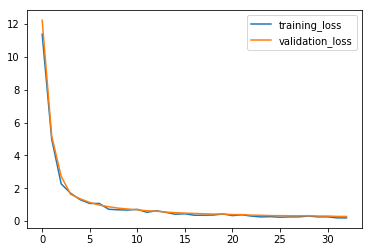

===============epoch:  3 =================
Training loss:  0.199375
Validation loss:  0.266971
Training accuracy:  0.941667
Validation accuracy:  0.925476


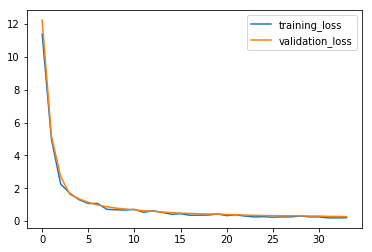

===============epoch:  3 =================
Training loss:  0.172117
Validation loss:  0.265769
Training accuracy:  0.943333
Validation accuracy:  0.926429


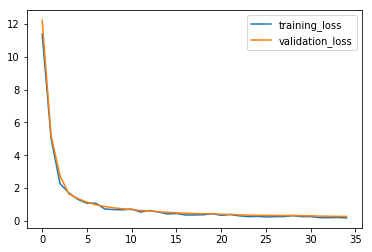

===============epoch:  3 =================
Training loss:  0.198595
Validation loss:  0.26375
Training accuracy:  0.938333
Validation accuracy:  0.925476


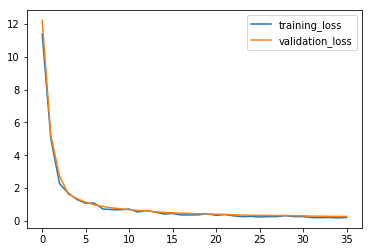

In [45]:
run_model(4, images, labels, 600, 0.3)

In [47]:
##############################################################
#                Part Five: Testing 
##############################################################

In [55]:
test_images = []

with open('test.csv') as test_file:
    # Skip first line.
    test_file.readline()
    
    csv_test_file = csv.reader(test_file, delimiter=',')
    for row in csv_test_file:
        test_images.append(np.array(row, dtype=float))

In [65]:
t_offset = 1

with open('test_output.csv', 'w') as test_output:
    test_output.write('ImageId,Label\n')
    
    test_loader = BatchLoader(test_images)

    
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)
        
        loaded_image_tensor = loaded_graph.get_tensor_by_name("conv_input:0")
        loaded_label_tensor = loaded_graph.get_tensor_by_name("conv_label:0")
        loaded_dropout_prob = loaded_graph.get_tensor_by_name("dropout_prob:0")
        loaded_logits = loaded_graph.get_tensor_by_name("logits:0")
    
        while True:
            test_image_batch = test_loader.load_batch_image(600)
            
            if len(test_image_batch) == 0:
                break
            
            labels = sess.run(loaded_logits, feed_dict={
                loaded_image_tensor: test_image_batch,
                loaded_dropout_prob: 0.0
            })
        
            labels = np.argmax(labels, axis=1)
        
            data = zip(range(t_offset, t_offset + len(labels)), labels)
        
            for d in data:
                test_output.write('%d,%d\n' % d)
            
            t_offset += len(labels)
        

INFO:tensorflow:Restoring parameters from ./kaggle_digit
